## Its a trial to demonstrate the Quantum Tomography
Preparing Environment


In [6]:
from scipy.linalg import expm
from scipy.sparse.linalg import eigsh
import numpy as np
import dataset
import pickle

In [4]:
# save states

N = 9
T = 1
J_list = [1]
h_list = [0, 0.2, 0.4, 0.6, 0.8, 1]

for h in h_list:
    ising_hamiltonian = dataset.IsingHamiltonian(n_qubits = N, J=J_list[0], h=h)

    simulator = dataset.GibbsStateSimulator(ising_hamiltonian)

    # Simulate the Gibbs state over a temperature range
    gibbs_states = simulator.simulate_temperature_scan(1, 2, 1)

    filename = f'gibbs_dataset/gibbs_ising_nq{N}_T{T}_h{h}'
    simulator.save_gibbs_states_to_pkl(gibbs_states, filename)



Gibbs states saved to gibbs_dataset/gibbs_ising_nq9_T1_h0
Gibbs states saved to gibbs_dataset/gibbs_ising_nq9_T1_h0.2
Gibbs states saved to gibbs_dataset/gibbs_ising_nq9_T1_h0.4
Gibbs states saved to gibbs_dataset/gibbs_ising_nq9_T1_h0.6
Gibbs states saved to gibbs_dataset/gibbs_ising_nq9_T1_h0.8
Gibbs states saved to gibbs_dataset/gibbs_ising_nq9_T1_h1


In [11]:
gibbs_states_allh = []
for idx in h_list:

    filename = f'gibbs_dataset/gibbs_ising_nq{N}_T{T}_h{h}'
    
    with open(filename, "rb") as f:
        gibbs_states = pickle.load(f)
        gibbs_states_allh.append(gibbs_states_allh)

### Local pauli term $<\sigma_1^z \sigma_j^z>$, $1 < j \leq N$

In [45]:
for idx in h_list:
    # load gibbs state
    filename = f'gibbs_dataset/gibbs_ising_nq{N}_T{T}_h{idx}'
    
    with open(filename, "rb") as f:
        gibbs_states = pickle.load(f)
        gibbs_states = gibbs_states[1]

    # obs
    corr_term_each_h = []
    for j in range(1, N):
        obs =  [dataset.Z] +  [dataset.I] * (N - 1)
        obs[j] = dataset.Z
        zz_obs = dataset.kron_n(obs)

        # calulate correlation term
        corr_term = np.trace(gibbs_states * zz_obs)
        corr_term_each_h.append(corr_term)
    
    print(corr_term_each_h)
    fn = f'correlation/gibbs_ising_nq{N}_T{T}_h{idx}_Z'
    np.save(fn, corr_term_each_h)
    

[(0.761594155955765+0j), (0.580025658385974+0j), (0.44174415173115256+0j), (0.3364297643860825+0j), (0.25622294244601534+0j), (0.19513789558867556+0j), (0.14861588088584157+0j), (0.11318498636487503+0j)]
[(0.7499873170410604+0j), (0.5678001211524062+0j), (0.42987952554727504+0j), (0.3254603402521629+0j), (0.24640492696720223+0j), (0.18655233502953372+0j), (0.14123700306991804+0j), (0.10666513619308172+0j)]
[(0.7167069393747811+0j), (0.5328956395114872+0j), (0.3963637304379163+0j), (0.2948137204894808+0j), (0.21928124955305517+0j), (0.16310027167388802+0j), (0.12129927235836+0j), (0.08938034847455786+0j)]
[(0.6660402688081193+0j), (0.48024430945537033+0j), (0.34685964152238113+0j), (0.2505342418946379+0j), (0.18095932267455062+0j), (0.13070418678467682+0j), (0.09436064598662137+0j), (0.06686021484911378+0j)]
[(0.6040900031615348+0j), (0.4168409095011484+0j), (0.28906384770480914+0j), (0.20050658609976557+0j), (0.13908130808748836+0j), (0.09646916868657862+0j), (0.06683510760309302+0j), 

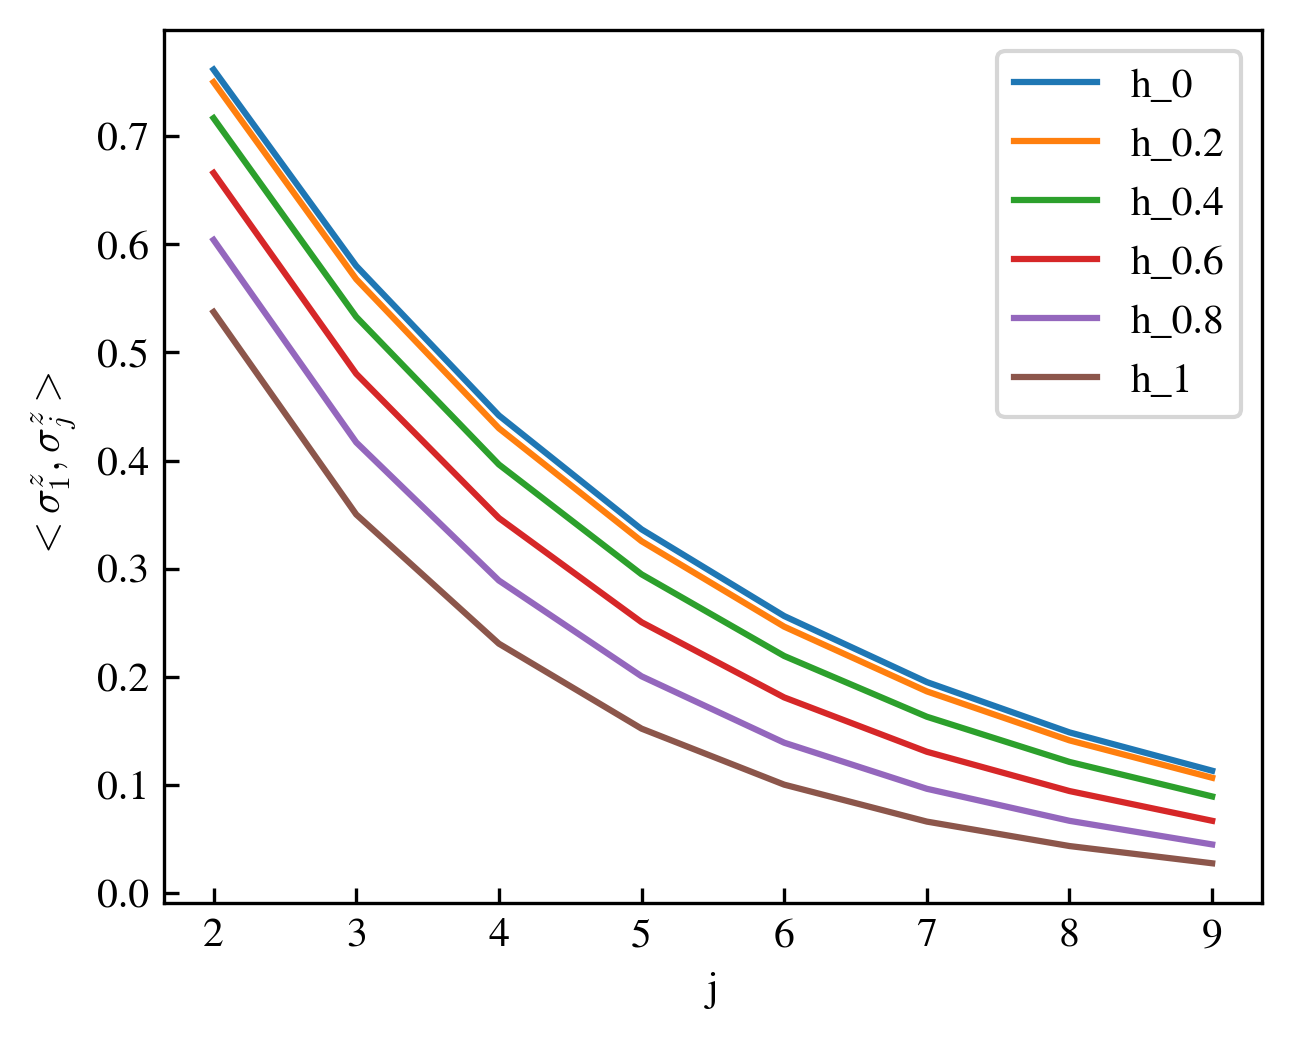

In [57]:
# define figure size
import matplotlib.pyplot as plt
centimeter_to_inch = 1 / 2.54
figure_width = centimeter_to_inch * 12
figure_height = figure_width * 0.8
fig = plt.figure(figsize=(figure_width, figure_height), dpi=300)  # size in inches
ax = fig.add_subplot(1, 1, 1)

# set all fonts
font_family = 'STIXGeneral'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = font_family

# set ticks in
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

# font size
font_size_name_xy = 30
font_size_tick_label = 26
font_size_legend = 16
font_xy = {'family': font_family, 'size': font_size_name_xy}
font_legend = {'family': font_family, 'size': font_size_legend}

for idx in h_list:
    fn = f'correlation/gibbs_ising_nq{N}_T{T}_h{idx}_Z.npy'
    corr_term = np.load(fn)

    plt.plot(range(2,N+1), corr_term, label=f'h_{idx}')
    plt.ylabel(r'$<\sigma_1^z, \sigma_j^z>$')
    plt.xlabel("j")

plt.legend()


### Renyi entropy with order 2

#S_A for A=[1,2...,i], where 1<= i <N